In [1]:
# import packages
# RDkit
# import packages
# RDkit
#from postera_gnn.data.featurize import *

from rdkit import Chem
from rdkit.Chem import GraphDescriptors
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

import numpy as np, pandas as pd
import torch
from pathlib import Path

%load_ext autoreload
%autoreload 2
df_data = pd.read_csv('data/kinase_JAK.csv')
df_data.head()

/home/mo/anaconda3/envs/dl1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,SMILES,measurement_type,measurement_value,Kinase_name
0,C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...,pIC50,6.81,JAK2
1,C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...,pIC50,8.05,JAK1
2,C#CCN(c1ccc(C#N)cn1)C1CCN(c2ncnc3[nH]ccc23)C1,pIC50,10.26,JAK2
3,C#CCN(c1ccc(C#N)cn1)C1CCN(c2ncnc3[nH]ccc23)C1,pIC50,10.26,JAK1
4,C#CCNCC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1,pIC50,7.36,JAK2


In [29]:
binding_df = pd.pivot_table(
  df_data, index='SMILES', columns='Kinase_name',
  values='measurement_value').reset_index()
binding_df.head(2)

Kinase_name,SMILES,JAK1,JAK2,JAK3,TYK2
0,BrCC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1,9.40,8.59,7.13,8.59
1,Brc1cc(CN2CCC(c3nnn4cnc5[nH]ccc5c34)CC2)sc1Br,7.68,7.15,NaN,NaN


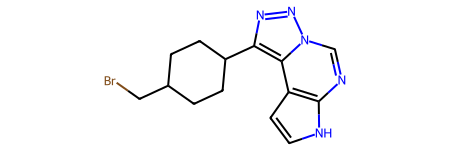

In [50]:
mol = Chem.MolFromSmiles(binding_df.SMILES[0])
mol

In [69]:
mol.GetSubstructMatches(Chem.MolFromSmarts(df_func_gps.iloc[3].SMILES))

()

<b> Functional groups

In [57]:
import numpy as np, pandas as pd
df_func_gps = pd.read_csv('data/functional_groups.csv', header=None)
df_func_gps.columns = ['SMILES', 'functional_groups']
df_func_gps.head()

,SMILES,functional_groups
0,[R]O,Alcohol
1,[R]C([R])=C([R])[R],Alkene
2,[R]C#C[R],Alkyne
3,[R]C=O,Aldehyde
4,[R]C=S,Thial


In [75]:
def get_func_groups_pos(smiles, df_func_gps=df_func_gps):
  mol = Chem.MolFromSmiles(smiles)
  onehot_func_gps = np.zeros(len(df_func_gps), dtype=int)
  for i, smiles in enumerate(df_func_gps['SMILES']):
    substruct = Chem.MolFromSmarts(smiles)
    match_pos = mol.GetSubstructMatches(substruct)
    onehot_func_gps[i] = len(match_pos)
  return pd.Series(onehot_func_gps,
                   index=df_func_gps.functional_groups)

func_gps = binding_df.SMILES.apply(
  lambda s: get_func_groups_pos(s, df_func_gps))
df_data_added = pd.concat([df_data, func_gps.astype(int)],
                          axis=1)
df_data_added.head(2)

,SMILES,measurement_type,measurement_value,Kinase_name,Alcohol,Alkene,Alkyne,Aldehyde,Thial,Ketone,...,Isocynate,Nitrate,Isonitrile,Nitrosooxy,Nitro,Nitroso,Aldoxime,Ketoxime,Carbamate,Nitrile
0,C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...,pIC50,6.81,JAK2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...,pIC50,8.05,JAK1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Analysis & Visualizations

In [76]:
import matplotlib as plt, seaborn as sb

<AxesSubplot: xlabel='Kinase_name', ylabel='measurement_value'>

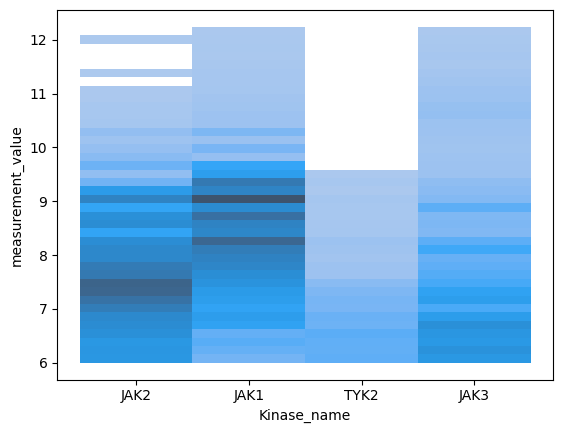

In [78]:
x, y = 'Kinase_name', 'measurement_value'
cols = [x, y]
sb.histplot(df_data_added[cols], x=x, y=y)